In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__MACOSX', '__notebook__.ipynb', 'plates']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['train', '.DS_Store', 'test']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5669.07it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(4, 32)

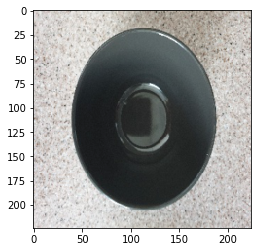

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

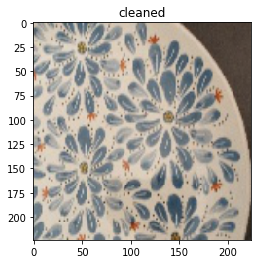

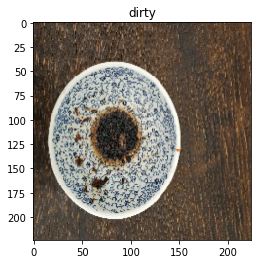

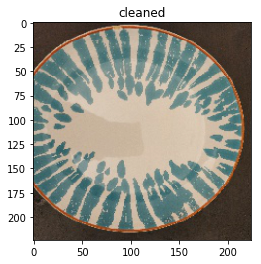

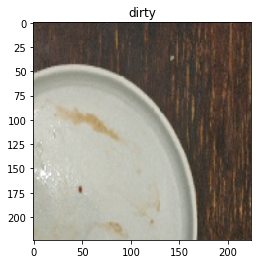

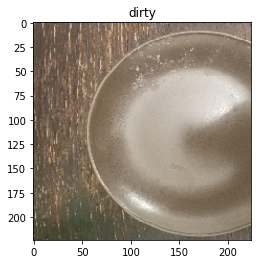

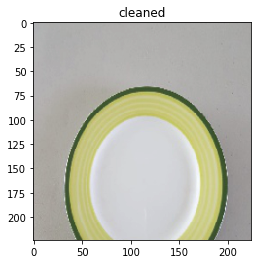

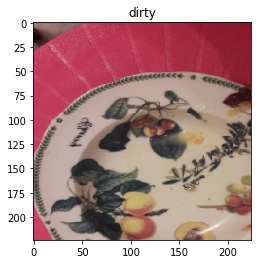

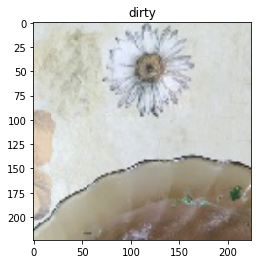

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 27310957.59it/s]


In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

train Loss: 0.6678 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

val Loss: 0.6928 Acc: 0.5000
Epoch 1/99:



100%|██████████| 4/4 [00:00<00:00,  9.64it/s]

train Loss: 0.6767 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

val Loss: 0.7162 Acc: 0.5000
Epoch 2/99:



100%|██████████| 4/4 [00:00<00:00,  9.41it/s]

train Loss: 0.5064 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.7550 Acc: 0.5000
Epoch 3/99:



100%|██████████| 4/4 [00:00<00:00,  9.44it/s]

train Loss: 0.5917 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

val Loss: 0.7717 Acc: 0.6250
Epoch 4/99:



100%|██████████| 4/4 [00:00<00:00,  8.69it/s]

train Loss: 0.6480 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.7883 Acc: 0.5000
Epoch 5/99:



100%|██████████| 4/4 [00:00<00:00,  9.47it/s]

train Loss: 0.5280 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

val Loss: 0.7864 Acc: 0.5000
Epoch 6/99:



100%|██████████| 4/4 [00:00<00:00,  9.32it/s]

train Loss: 0.4851 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

val Loss: 0.8041 Acc: 0.5000
Epoch 7/99:



100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

train Loss: 0.4895 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

val Loss: 0.7893 Acc: 0.5000
Epoch 8/99:



100%|██████████| 4/4 [00:00<00:00,  8.78it/s]

train Loss: 0.5012 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.7851 Acc: 0.5000
Epoch 9/99:



100%|██████████| 4/4 [00:00<00:00,  8.97it/s]

train Loss: 0.5072 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

val Loss: 0.7779 Acc: 0.5000
Epoch 10/99:



100%|██████████| 4/4 [00:00<00:00,  9.66it/s]

train Loss: 0.4399 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

val Loss: 0.7832 Acc: 0.5000
Epoch 11/99:



100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

train Loss: 0.5120 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.7841 Acc: 0.5000
Epoch 12/99:



100%|██████████| 4/4 [00:00<00:00,  9.45it/s]

train Loss: 0.4152 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

val Loss: 0.7980 Acc: 0.5000
Epoch 13/99:



100%|██████████| 4/4 [00:00<00:00,  8.98it/s]

train Loss: 0.4780 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

val Loss: 0.7891 Acc: 0.5000
Epoch 14/99:



100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

train Loss: 0.4645 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

val Loss: 0.8021 Acc: 0.5000
Epoch 15/99:



100%|██████████| 4/4 [00:00<00:00,  9.12it/s]

train Loss: 0.5323 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.7974 Acc: 0.5000
Epoch 16/99:



100%|██████████| 4/4 [00:00<00:00,  9.47it/s]

train Loss: 0.5720 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

val Loss: 0.7904 Acc: 0.6250
Epoch 17/99:



100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

train Loss: 0.4492 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.7957 Acc: 0.6250
Epoch 18/99:



100%|██████████| 4/4 [00:00<00:00,  9.43it/s]

train Loss: 0.5790 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

val Loss: 0.7964 Acc: 0.5000
Epoch 19/99:



100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

train Loss: 0.4886 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

val Loss: 0.7920 Acc: 0.5000
Epoch 20/99:



100%|██████████| 4/4 [00:00<00:00,  9.49it/s]

train Loss: 0.4629 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

val Loss: 0.7908 Acc: 0.5000
Epoch 21/99:



100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

train Loss: 0.4794 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

val Loss: 0.7948 Acc: 0.5000
Epoch 22/99:



100%|██████████| 4/4 [00:00<00:00,  9.57it/s]

train Loss: 0.5154 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

val Loss: 0.8093 Acc: 0.5000
Epoch 23/99:



100%|██████████| 4/4 [00:00<00:00,  9.28it/s]

train Loss: 0.5420 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

val Loss: 0.8088 Acc: 0.5000
Epoch 24/99:



100%|██████████| 4/4 [00:00<00:00,  9.42it/s]

train Loss: 0.5170 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

val Loss: 0.8092 Acc: 0.5000
Epoch 25/99:



100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

train Loss: 0.5432 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.7974 Acc: 0.5000
Epoch 26/99:



100%|██████████| 4/4 [00:00<00:00,  9.82it/s]

train Loss: 0.4433 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

val Loss: 0.7980 Acc: 0.5000
Epoch 27/99:



100%|██████████| 4/4 [00:00<00:00,  9.53it/s]

train Loss: 0.4380 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

val Loss: 0.7833 Acc: 0.5000
Epoch 28/99:



100%|██████████| 4/4 [00:00<00:00,  9.40it/s]

train Loss: 0.4175 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.7742 Acc: 0.5000
Epoch 29/99:



100%|██████████| 4/4 [00:00<00:00,  9.67it/s]

train Loss: 0.4398 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

val Loss: 0.7734 Acc: 0.5000
Epoch 30/99:



100%|██████████| 4/4 [00:00<00:00,  9.48it/s]

train Loss: 0.4830 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

val Loss: 0.7952 Acc: 0.5000
Epoch 31/99:



100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

train Loss: 0.4684 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

val Loss: 0.8018 Acc: 0.5000
Epoch 32/99:



100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

train Loss: 0.5122 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.7887 Acc: 0.5000
Epoch 33/99:



100%|██████████| 4/4 [00:00<00:00,  9.49it/s]

train Loss: 0.4585 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

val Loss: 0.7798 Acc: 0.5000
Epoch 34/99:



100%|██████████| 4/4 [00:00<00:00,  9.49it/s]

train Loss: 0.4697 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

val Loss: 0.7768 Acc: 0.6250
Epoch 35/99:



100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

train Loss: 0.5021 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

val Loss: 0.7919 Acc: 0.5000
Epoch 36/99:



100%|██████████| 4/4 [00:00<00:00,  9.68it/s]

train Loss: 0.5531 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.7936 Acc: 0.6250
Epoch 37/99:



100%|██████████| 4/4 [00:00<00:00,  9.51it/s]

train Loss: 0.4887 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.8009 Acc: 0.5000
Epoch 38/99:



100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

train Loss: 0.4338 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

val Loss: 0.7886 Acc: 0.6250
Epoch 39/99:



100%|██████████| 4/4 [00:00<00:00,  9.45it/s]

train Loss: 0.4796 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.7906 Acc: 0.5000
Epoch 40/99:



100%|██████████| 4/4 [00:00<00:00,  9.57it/s]

train Loss: 0.4663 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

val Loss: 0.8016 Acc: 0.6250
Epoch 41/99:



100%|██████████| 4/4 [00:00<00:00,  9.55it/s]

train Loss: 0.5330 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.7965 Acc: 0.6250
Epoch 42/99:



100%|██████████| 4/4 [00:00<00:00,  9.26it/s]

train Loss: 0.4189 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.7936 Acc: 0.6250
Epoch 43/99:



100%|██████████| 4/4 [00:00<00:00,  9.34it/s]

train Loss: 0.4443 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

val Loss: 0.7781 Acc: 0.6250
Epoch 44/99:



100%|██████████| 4/4 [00:00<00:00,  9.58it/s]

train Loss: 0.4190 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

val Loss: 0.7779 Acc: 0.6250
Epoch 45/99:



100%|██████████| 4/4 [00:00<00:00,  9.51it/s]

train Loss: 0.3799 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.7775 Acc: 0.6250
Epoch 46/99:



100%|██████████| 4/4 [00:00<00:00,  9.08it/s]

train Loss: 0.4581 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

val Loss: 0.7770 Acc: 0.6250
Epoch 47/99:



100%|██████████| 4/4 [00:00<00:00,  8.87it/s]

train Loss: 0.5458 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.7796 Acc: 0.5000
Epoch 48/99:



100%|██████████| 4/4 [00:00<00:00,  9.39it/s]

train Loss: 0.4418 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

val Loss: 0.7949 Acc: 0.5000
Epoch 49/99:



100%|██████████| 4/4 [00:00<00:00,  8.24it/s]

train Loss: 0.4703 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

val Loss: 0.8003 Acc: 0.5000
Epoch 50/99:



100%|██████████| 4/4 [00:00<00:00,  9.39it/s]

train Loss: 0.4944 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.7912 Acc: 0.5000
Epoch 51/99:



100%|██████████| 4/4 [00:00<00:00,  9.67it/s]

train Loss: 0.4349 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

val Loss: 0.8027 Acc: 0.5000
Epoch 52/99:



100%|██████████| 4/4 [00:00<00:00,  9.49it/s]

train Loss: 0.4826 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.7775 Acc: 0.5000
Epoch 53/99:



100%|██████████| 4/4 [00:00<00:00,  8.95it/s]

train Loss: 0.4769 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

val Loss: 0.7820 Acc: 0.5000
Epoch 54/99:



100%|██████████| 4/4 [00:00<00:00,  9.01it/s]

train Loss: 0.5449 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

val Loss: 0.7854 Acc: 0.6250
Epoch 55/99:



100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

train Loss: 0.4153 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.7793 Acc: 0.5000
Epoch 56/99:



100%|██████████| 4/4 [00:00<00:00,  9.48it/s]

train Loss: 0.4556 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

val Loss: 0.7637 Acc: 0.6250
Epoch 57/99:



100%|██████████| 4/4 [00:00<00:00,  9.44it/s]

train Loss: 0.4586 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

val Loss: 0.7681 Acc: 0.5000
Epoch 58/99:



100%|██████████| 4/4 [00:00<00:00,  9.43it/s]

train Loss: 0.4386 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

val Loss: 0.7858 Acc: 0.6250
Epoch 59/99:



100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

train Loss: 0.4997 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.7772 Acc: 0.6250
Epoch 60/99:



100%|██████████| 4/4 [00:00<00:00,  9.56it/s]

train Loss: 0.4609 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

val Loss: 0.7750 Acc: 0.5000
Epoch 61/99:



100%|██████████| 4/4 [00:00<00:00,  9.64it/s]

train Loss: 0.4643 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

val Loss: 0.7872 Acc: 0.5000
Epoch 62/99:



100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

train Loss: 0.4978 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

val Loss: 0.7925 Acc: 0.5000
Epoch 63/99:



100%|██████████| 4/4 [00:00<00:00,  9.43it/s]

train Loss: 0.5107 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.8109 Acc: 0.5000
Epoch 64/99:



100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

train Loss: 0.4579 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

val Loss: 0.7964 Acc: 0.5000
Epoch 65/99:



100%|██████████| 4/4 [00:00<00:00,  9.69it/s]

train Loss: 0.4510 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

val Loss: 0.7823 Acc: 0.5000
Epoch 66/99:



100%|██████████| 4/4 [00:00<00:00,  9.61it/s]

train Loss: 0.4519 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

val Loss: 0.7804 Acc: 0.5000
Epoch 67/99:



100%|██████████| 4/4 [00:00<00:00,  9.45it/s]

train Loss: 0.5322 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

val Loss: 0.7850 Acc: 0.5000
Epoch 68/99:



100%|██████████| 4/4 [00:00<00:00,  9.62it/s]

train Loss: 0.4596 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

val Loss: 0.7767 Acc: 0.5000
Epoch 69/99:



100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

train Loss: 0.4439 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.7752 Acc: 0.6250
Epoch 70/99:



100%|██████████| 4/4 [00:00<00:00,  9.05it/s]

train Loss: 0.4383 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.7854 Acc: 0.5000
Epoch 71/99:



100%|██████████| 4/4 [00:00<00:00,  9.39it/s]

train Loss: 0.4346 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

val Loss: 0.7871 Acc: 0.5000
Epoch 72/99:



100%|██████████| 4/4 [00:00<00:00,  9.41it/s]

train Loss: 0.4432 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

val Loss: 0.7851 Acc: 0.5000
Epoch 73/99:



100%|██████████| 4/4 [00:00<00:00,  9.17it/s]

train Loss: 0.4775 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.7713 Acc: 0.5000
Epoch 74/99:



100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

train Loss: 0.4338 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.7807 Acc: 0.5000
Epoch 75/99:



100%|██████████| 4/4 [00:00<00:00,  9.35it/s]

train Loss: 0.4310 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

val Loss: 0.7863 Acc: 0.5000
Epoch 76/99:



100%|██████████| 4/4 [00:00<00:00,  9.48it/s]

train Loss: 0.4896 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

val Loss: 0.7905 Acc: 0.5000
Epoch 77/99:



100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

train Loss: 0.4572 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.7898 Acc: 0.6250
Epoch 78/99:



100%|██████████| 4/4 [00:00<00:00,  9.62it/s]

train Loss: 0.4997 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

val Loss: 0.7987 Acc: 0.5000
Epoch 79/99:



100%|██████████| 4/4 [00:00<00:00,  9.66it/s]

train Loss: 0.5206 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

val Loss: 0.7888 Acc: 0.5000
Epoch 80/99:



100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

train Loss: 0.4129 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 0.7729 Acc: 0.5000
Epoch 81/99:



100%|██████████| 4/4 [00:00<00:00,  9.33it/s]

train Loss: 0.5202 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

val Loss: 0.7715 Acc: 0.5000
Epoch 82/99:



100%|██████████| 4/4 [00:00<00:00,  9.59it/s]

train Loss: 0.5448 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.7708 Acc: 0.6250
Epoch 83/99:



100%|██████████| 4/4 [00:00<00:00,  9.30it/s]

train Loss: 0.4375 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

val Loss: 0.7805 Acc: 0.5000
Epoch 84/99:



100%|██████████| 4/4 [00:00<00:00,  9.00it/s]

train Loss: 0.3997 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.7872 Acc: 0.5000
Epoch 85/99:



100%|██████████| 4/4 [00:00<00:00,  9.28it/s]

train Loss: 0.4231 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

val Loss: 0.7988 Acc: 0.5000
Epoch 86/99:



100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

train Loss: 0.4784 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

val Loss: 0.7836 Acc: 0.5000
Epoch 87/99:



100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

train Loss: 0.4777 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

val Loss: 0.7822 Acc: 0.5000
Epoch 88/99:



100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

train Loss: 0.4677 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.7951 Acc: 0.5000
Epoch 89/99:



100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

train Loss: 0.4643 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.7928 Acc: 0.5000
Epoch 90/99:



100%|██████████| 4/4 [00:00<00:00,  5.90it/s]

train Loss: 0.5176 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

val Loss: 0.7776 Acc: 0.6250
Epoch 91/99:



100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

train Loss: 0.4526 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.7752 Acc: 0.6250
Epoch 92/99:



100%|██████████| 4/4 [00:00<00:00,  8.84it/s]

train Loss: 0.5114 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 0.7941 Acc: 0.5000
Epoch 93/99:



100%|██████████| 4/4 [00:00<00:00,  9.09it/s]

train Loss: 0.4499 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

val Loss: 0.7916 Acc: 0.6250
Epoch 94/99:



100%|██████████| 4/4 [00:00<00:00,  9.42it/s]

train Loss: 0.4680 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

val Loss: 0.8013 Acc: 0.5000
Epoch 95/99:



100%|██████████| 4/4 [00:00<00:00,  9.36it/s]

train Loss: 0.4512 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

val Loss: 0.7876 Acc: 0.5000
Epoch 96/99:



100%|██████████| 4/4 [00:00<00:00,  9.31it/s]

train Loss: 0.4516 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.7760 Acc: 0.5000
Epoch 97/99:



100%|██████████| 4/4 [00:00<00:00,  9.27it/s]

train Loss: 0.4633 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

val Loss: 0.7916 Acc: 0.5000
Epoch 98/99:



100%|██████████| 4/4 [00:00<00:00,  9.05it/s]

train Loss: 0.4538 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

val Loss: 0.7874 Acc: 0.6250
Epoch 99/99:



100%|██████████| 4/4 [00:00<00:00,  9.49it/s]

train Loss: 0.4717 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

val Loss: 0.7922 Acc: 0.5000


In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [15]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 25.44it/s]


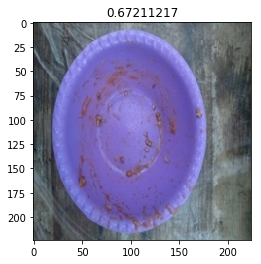

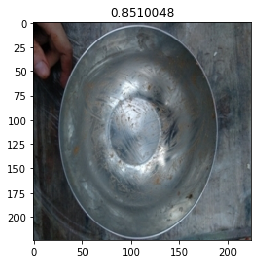

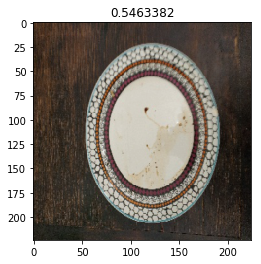

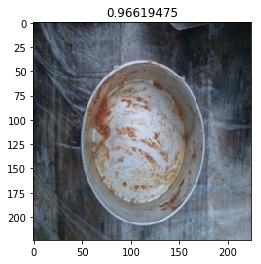

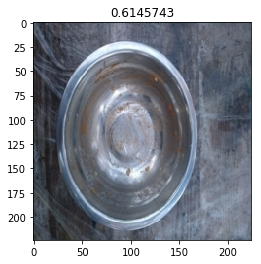

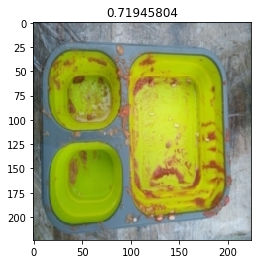

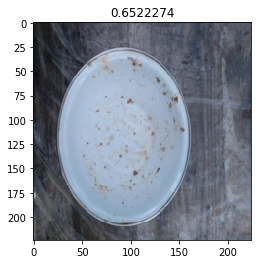

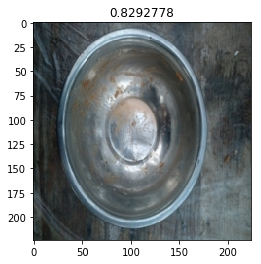

In [16]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [17]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [19]:
submission_df.to_csv('submission.csv')

In [20]:
!rm -rf train val test